Preprocessing data:
1. filter out data with values <null> under column Longitude and Latitude.
    We have check is there any data only have either longitude or latitude. Fortunately, all of them are in the right way.
2. filter out data with values <null> under column Score.
3. filter out data with values <null> under column Grade.
4. because we leave the grade, so we create a column called year based on the graded date.
5. cluster and column "STREET" and "DBA"

In [72]:
!pip install --upgrade geopandas
!pip install --upgrade pygeos
!apt-get install -qq curl g++ make
!curl -L http://download.osgeo.org/libspatialindex/spatialindex-src-1.8.5.tar.gz | tar xz
import os
os.chdir('spatialindex-src-1.8.5')
!./configure
!make
!make install
!pip install rtree
!ldconfig
!./configure
!make
!make install
!pip install rtree
!ldconfig
!pip install --upgrade contextily
%cd ..
!unzip blocks.zip
!unzip nynta.zip

Requirement already up-to-date: geopandas in /usr/local/lib/python3.6/dist-packages (0.8.1)
Requirement already up-to-date: pygeos in /usr/local/lib/python3.6/dist-packages (0.8)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  556k  100  556k    0     0   993k      0 --:--:-- --:--:-- --:--:--  993k
checking build system type... x86_64-unknown-linux-gnu
checking for g++... g++
checking whether the C++ compiler works... yes
checking for C++ compiler default output file name... a.out
checking for suffix of executables... 
checking whether we are cross compiling... no
checking for suffix of object files... o
checking whether we are using the GNU C++ compiler... yes
checking whether g++ accepts -g... yes
checking how to run the C++ preprocessor... g++ -E
checking for a BSD-compatible install... /usr/bin/install -c
checking whether ln -s works... yes
checking whether make sets 

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import descartes
import contextily as ctx

In [74]:
data = pd.read_csv('project_data.csv')

In [75]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
%matplotlib inline

### We can see that one restaurant have multiple records on different record date. 
But we also see a date information called inspection date, we need to see how do this date data work.

In [76]:
data2 = pd.read_csv('project_data2.csv')

### We can see that it is a different from graded year we created, so we use inspection year as a year scale.

Exclude inspection year 2012,2013,2014,2015, maybe 2016.

Combine longitude, latitude.

## Find top 5~10 cuisine in NYC. Find their violations.

## Try to Geo

In [77]:
data3 = data2[data2.Latitude != 0]
data3 = data3[data3.Longitude != 0]

In [78]:
boros = gpd.read_file(gpd.datasets.get_path("nybb"))

In [79]:
geometry = [Point(xy) for xy in zip(data3["Longitude"], data3["Latitude"])]
geometry[:3]
geo_df = gpd.GeoDataFrame(data3, geometry = geometry)

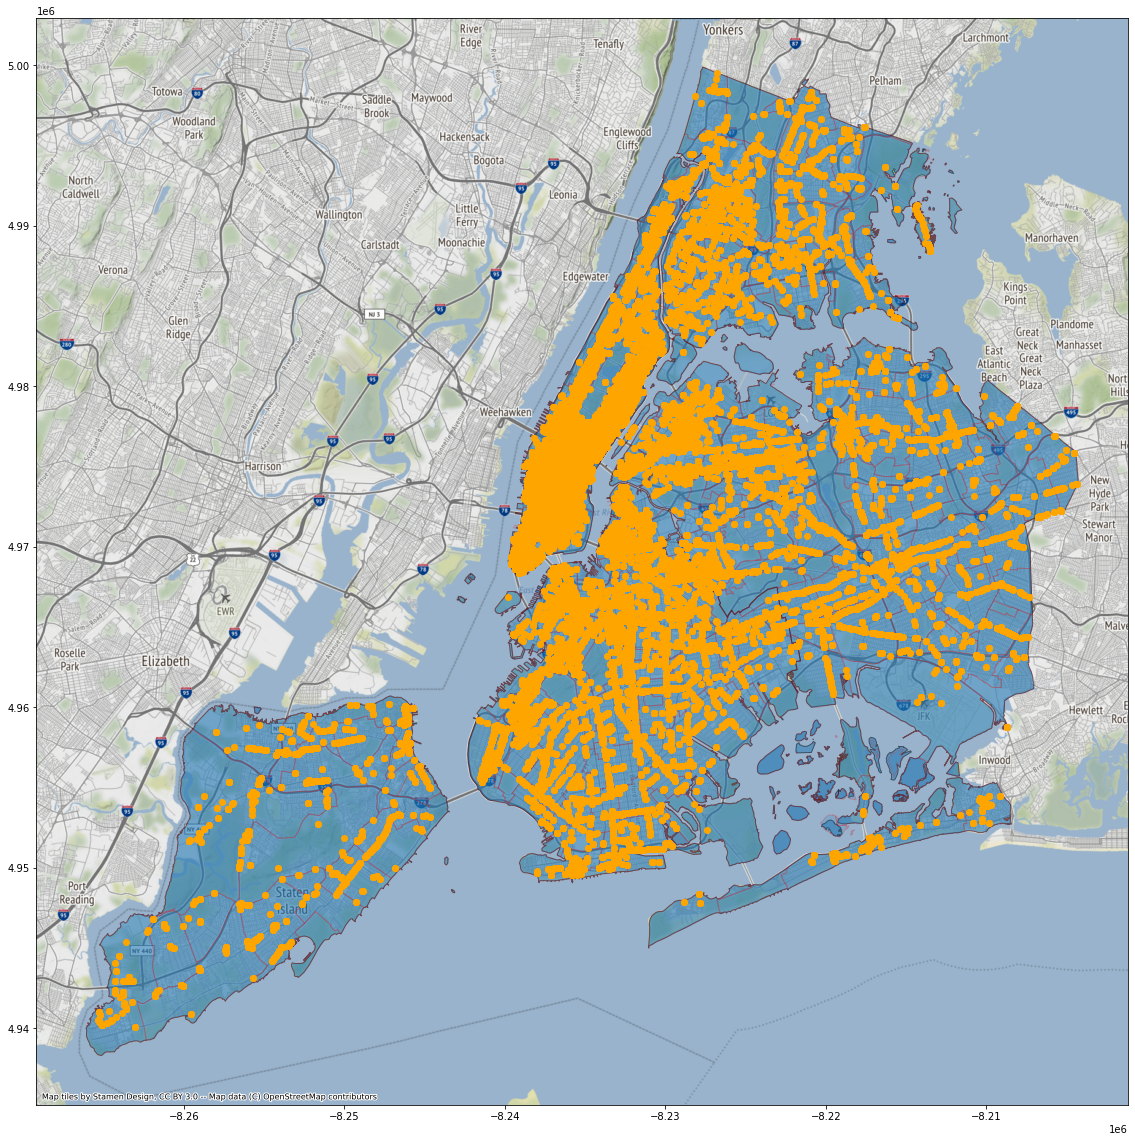

In [80]:
import contextily as ctx
test = geo_df
test = test[test['Inspection_year'] == 2019]
#test = test[test['GRADE'] == 'C']
test.crs = 4326
test = test.to_crs(epsg=3857)

boros = gpd.read_file(gpd.datasets.get_path("nybb"))
boros = boros.to_crs(epsg=3857)

nta = gpd.GeoDataFrame.from_file('neighborhood/')
nta.drop('BoroCode', axis=1, inplace=True)
nta.drop('CountyFIPS', axis=1, inplace=True)
nta.drop('Shape_Leng', axis=1, inplace=True)
nta.drop('Shape_Area', axis=1, inplace=True)
nta.drop('NTACode', axis=1, inplace=True)
nta.drop('BoroName', axis=1, inplace=True)
nta = nta.to_crs(epsg=3857)
id = range(nta.NTAName.count())
nta.insert(0, "id", id, True)

fig, ax = plt.subplots(figsize=(40,20))
boros.plot(ax=ax, alpha=0.5, edgecolor="black")
nta.plot(ax=ax, alpha=0.2, edgecolor="red")
test.plot(ax=ax, color="orange")

ctx.add_basemap(ax, zoom = 12)

In [81]:
airbnb = pd.read_csv('AB_NYC_2019.csv')
airbnb.drop('id', axis=1, inplace=True)
airbnb.drop('host_id', axis=1, inplace=True)
airbnb.drop('host_name', axis=1, inplace=True)
airbnb.drop('neighbourhood_group', axis=1, inplace=True)
airbnb.drop('neighbourhood', axis=1, inplace=True)
airbnb.drop('room_type', axis=1, inplace=True)
airbnb.drop('minimum_nights', axis=1, inplace=True)
airbnb.drop('number_of_reviews', axis=1, inplace=True)
airbnb.drop('last_review', axis=1, inplace=True)
airbnb.drop('reviews_per_month', axis=1, inplace=True)
airbnb.drop('calculated_host_listings_count', axis=1, inplace=True)
airbnb.drop('availability_365', axis=1, inplace=True)

geobnb = gpd.GeoDataFrame(airbnb, geometry=gpd.points_from_xy(airbnb.longitude, airbnb.latitude))
geobnb.crs = 4326
geobnb = geobnb.to_crs(epsg=3857)

bnb_nta = gpd.sjoin(geobnb, nta, how="left")
bnb_nta

,name,latitude,longitude,price,geometry,index_right,id,NTAName
0,Clean & quiet apt home by the park,40.64749,-73.97237,149,POINT (-8234566.561 4960484.741),64.0,64.0,Windsor Terrace
1,Skylit Midtown Castle,40.75362,-73.98377,225,POINT (-8235835.603 4976068.312),57.0,57.0,Midtown-Midtown South
2,THE VILLAGE OF HARLEM....NEW YORK !,40.80902,-73.94190,150,POINT (-8231174.656 4984212.838),73.0,73.0,Central Harlem North-Polo Grounds
3,Cozy Entire Floor of Brownstone,40.68514,-73.95976,89,POINT (-8233162.822 4966010.228),12.0,12.0,Clinton Hill
4,Entire Apt: Spacious Studio/Loft by central park,40.79851,-73.94399,80,POINT (-8231407.314 4982667.208),107.0,107.0,East Harlem North
...,...,...,...,...,...,...,...,...
48890,Charming one bedroom - newly renovated rowhouse,40.67853,-73.94995,70,POINT (-8232070.778 4965039.924),174.0,174.0,Crown Heights North
48891,Affordable room in Bushwick/East Williamsburg,40.70184,-73.93317,40,POINT (-8230202.837 4968462.107),26.0,26.0,Bushwick South
48892,Sunny Studio at Historical Neighborhood,40.81475,-73.94867,115,POINT (-8231928.289 4985055.611),73.0,73.0,Central Harlem North-Polo Grounds
48893,43rd St. Time Square-cozy single bed,40.75751,-73.99112,55,POINT (-8236653.802 4976639.971),38.0,38.0,Clinton


In [82]:
nei_stats = bnb_nta.groupby('index_right')['price'].agg(['mean','std','max','min'])

bnb_nta_stats = pd.merge(nta, nei_stats , left_on='id',right_index=True,how='outer')
bnb_nta_stats

,id,NTAName,geometry,mean,std,max,min
0,0,Borough Park,"POLYGON ((-8234976.145 4958106.133, -8235100.3...",66.661972,40.471487,300.0,25.0
1,1,Murray Hill,"POLYGON ((-8215800.347 4979300.334, -8215488.5...",93.159420,126.564518,1000.0,27.0
2,2,East Elmhurst,"POLYGON ((-8222179.735 4977544.478, -8222049.7...",73.078947,44.313057,257.0,16.0
3,3,Hollis,"POLYGON ((-8210620.260 4970855.647, -8210467.9...",69.772727,31.406599,175.0,45.0
4,4,Homecrest,"POLYGON ((-8233032.889 4955044.931, -8232998.1...",76.490909,49.009021,300.0,20.0
...,...,...,...,...,...,...,...
190,190,Elmhurst,"POLYGON ((-8222938.087 4974791.930, -8222934.3...",80.400000,64.750134,443.0,15.0
191,191,Elmhurst-Maspeth,"POLYGON ((-8225592.038 4975067.875, -8225552.0...",72.792079,41.909740,200.0,28.0
192,192,Todt Hill-Emerson Hill-Heartland Village-Light...,"POLYGON ((-8248525.990 4955077.274, -8248474.2...",111.800000,98.834783,429.0,43.0
193,193,Old Town-Dongan Hills-South Beach,"POLYGON ((-8244881.795 4951905.650, -8244881.7...",80.827586,60.317653,275.0,20.0


In [83]:
test.drop('DBA', axis=1, inplace=True)
test.drop('BORO', axis=1, inplace=True)
test.drop('BUILDING', axis=1, inplace=True)
test.drop('STREET', axis=1, inplace=True)
test.drop('ZIPCODE', axis=1, inplace=True)
test.drop('PHONE', axis=1, inplace=True)
test.drop('CUISINE DESCRIPTION', axis=1, inplace=True)
test.drop('INSPECTION DATE', axis=1, inplace=True)
test.drop('ACTION', axis=1, inplace=True)
test.drop('VIOLATION CODE', axis=1, inplace=True)
test.drop('VIOLATION DESCRIPTION', axis=1, inplace=True)
test.drop('CRITICAL FLAG', axis=1, inplace=True)
test.drop('SCORE', axis=1, inplace=True)
test.drop('GRADE DATE', axis=1, inplace=True)
test.drop('year', axis=1, inplace=True)
test.drop('RECORD DATE', axis=1, inplace=True)
test.drop('INSPECTION TYPE', axis=1, inplace=True)
test.drop('Latitude', axis=1, inplace=True)
test.drop('Longitude', axis=1, inplace=True)
test.drop('Community Board', axis=1, inplace=True)
test.drop('Council District', axis=1, inplace=True)
test.drop('Census Tract', axis=1, inplace=True)
test.drop('BIN', axis=1, inplace=True)
test.drop('BBL', axis=1, inplace=True)
test.drop('NTA', axis=1, inplace=True)
test

,CAMIS,Inspection_year,GRADE,geometry
11,41377819,2019,A,POINT (-8236141.215 4963042.982)
13,50046429,2019,B,POINT (-8222643.086 4975984.409)
14,50044197,2019,A,POINT (-8219210.677 4980189.088)
15,41427673,2019,A,POINT (-8235649.151 4977397.954)
16,41661008,2019,A,POINT (-8232512.984 4979195.331)
...,...,...,...,...
201180,40698892,2019,A,POINT (-8236822.470 4973551.632)
201183,50043160,2019,A,POINT (-8228605.320 4978514.251)
201186,41310522,2019,A,POINT (-8228064.958 4977507.180)
201188,50049226,2019,A,POINT (-8235605.906 4955513.565)


In [84]:
test = test[test.GRADE != 'P']
test = test[test.GRADE != 'N']
test = test[test.GRADE != 'Z']
grades = test['GRADE']
scores = []
for r in grades:
  if r == 'A':
    r = 300
  elif r == 'B':
    r = 200
  else:
    r = 100
  scores.append(r)
test['GRADE'] = scores
test
res_nta = gpd.sjoin(test, nta, how="left")
res_nta

res_stats = res_nta.groupby('index_right')['GRADE'].agg(['mean','std','max','min'])

res_nta_stats = pd.merge(nta, res_stats , left_on='id',right_index=True,how='outer')
res_nta_stats

,id,NTAName,geometry,mean,std,max,min
0,0,Borough Park,"POLYGON ((-8234976.145 4958106.133, -8235100.3...",279.435484,47.832407,300.0,100.0
1,1,Murray Hill,"POLYGON ((-8215800.347 4979300.334, -8215488.5...",265.277778,64.341922,300.0,100.0
2,2,East Elmhurst,"POLYGON ((-8222179.735 4977544.478, -8222049.7...",281.132075,39.311231,300.0,200.0
3,3,Hollis,"POLYGON ((-8210620.260 4970855.647, -8210467.9...",293.055556,25.599235,300.0,200.0
4,4,Homecrest,"POLYGON ((-8233032.889 4955044.931, -8232998.1...",283.728814,47.448443,300.0,100.0
...,...,...,...,...,...,...,...
190,190,Elmhurst,"POLYGON ((-8222938.087 4974791.930, -8222934.3...",277.985075,50.653707,300.0,100.0
191,191,Elmhurst-Maspeth,"POLYGON ((-8225592.038 4975067.875, -8225552.0...",270.967742,54.400217,300.0,100.0
192,192,Todt Hill-Emerson Hill-Heartland Village-Light...,"POLYGON ((-8248525.990 4955077.274, -8248474.2...",284.210526,39.657981,300.0,100.0
193,193,Old Town-Dongan Hills-South Beach,"POLYGON ((-8244881.795 4951905.650, -8244881.7...",294.444444,23.034469,300.0,200.0


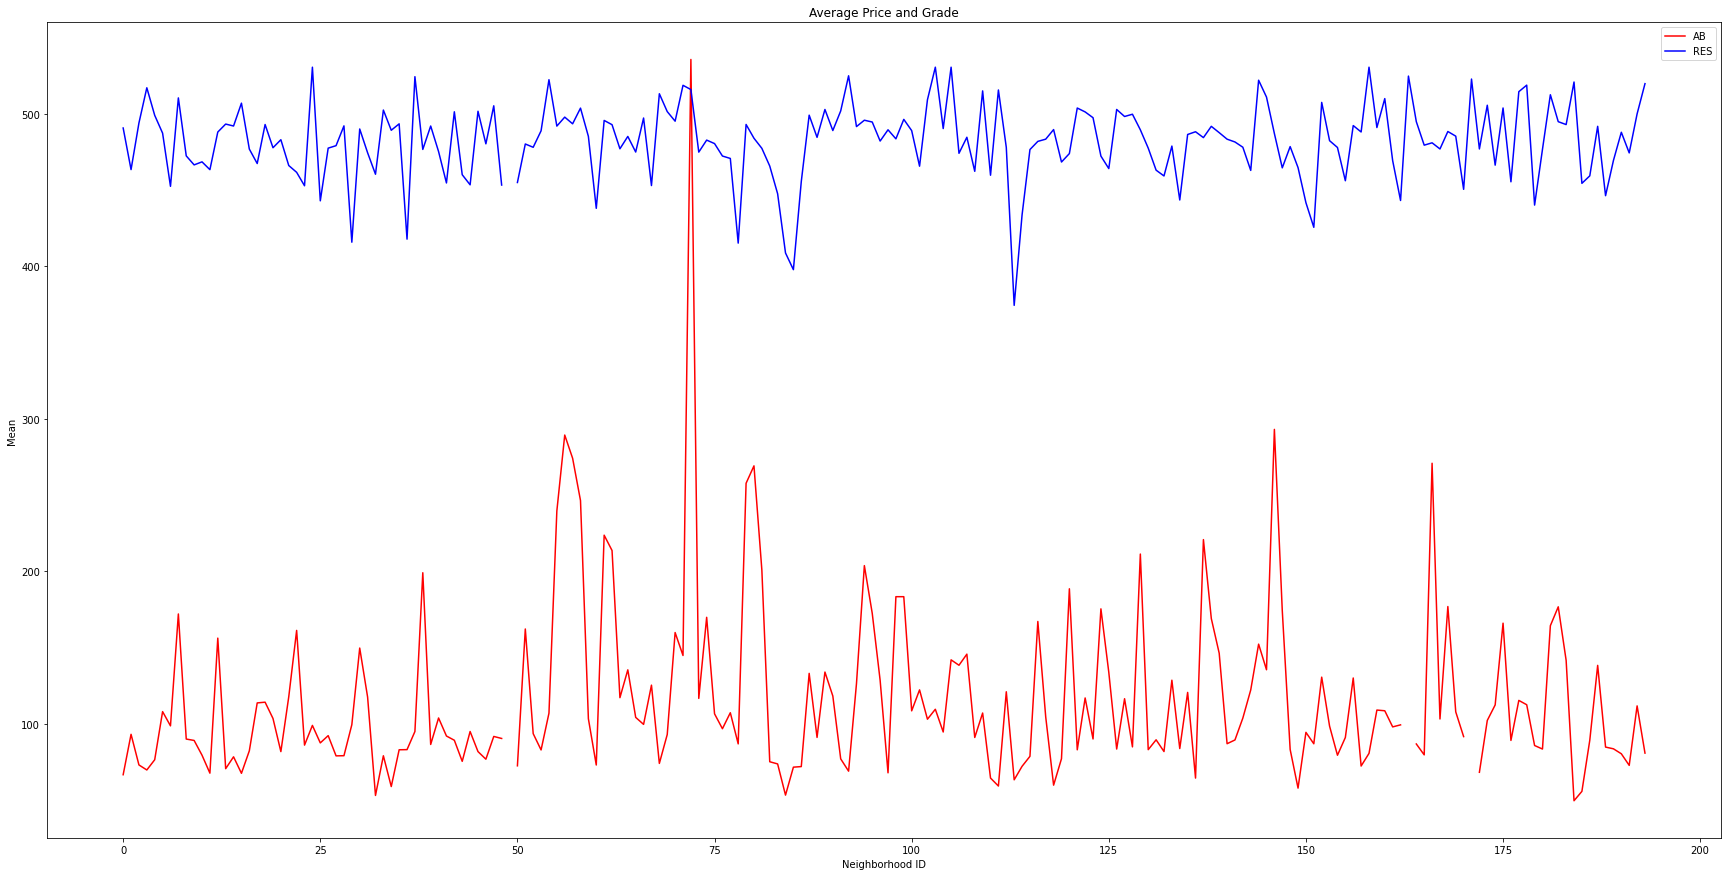

In [85]:
import math
x = bnb_nta_stats['id']
y1 = bnb_nta_stats['mean']
y = res_nta_stats['mean']
y2 = [i**(1.1) for i in y]

plt.figure(figsize=(30,15))
plt.plot(x,y1,color='red',label='AB')
plt.plot(x,y2,color='blue',label='RES')

plt.title(u'Average Price and Grade')
plt.xlabel(u'Neighborhood ID')
plt.ylabel(u'Mean')

plt.legend()

plt.show()

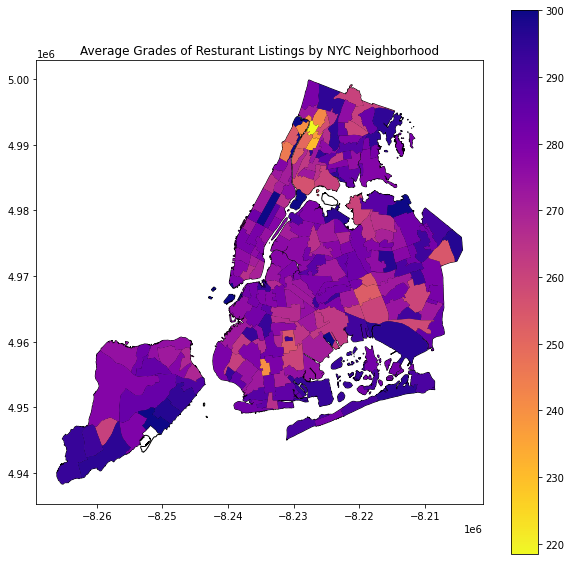

In [86]:


fig,ax = plt.subplots(1,1, figsize=(10,10))

base = nta.plot(color='white', edgecolor='black', ax=ax)

plt.title("Average Grades of Resturant Listings by NYC Neighborhood")

res_nta_stats.plot(column='mean', cmap='plasma_r', ax=base, legend=True)

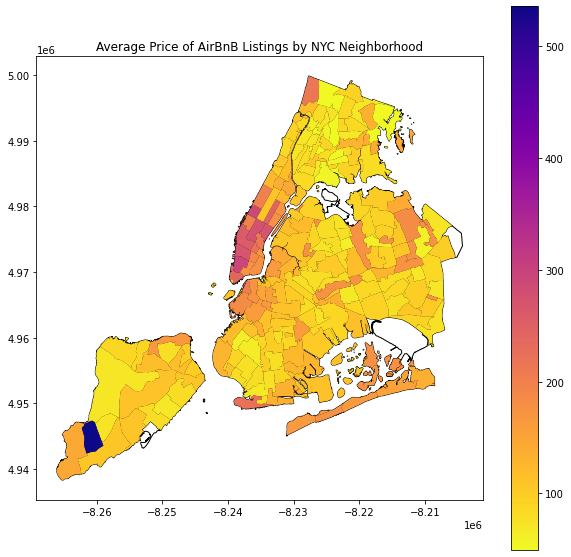

In [87]:
fig,ax = plt.subplots(1,1, figsize=(10,10))

base = nta.plot(color='white', edgecolor='black', ax=ax)

plt.title("Average Price of AirBnB Listings by NYC Neighborhood")

bnb_nta_stats.plot(column='mean', cmap='plasma_r', ax=base, legend=True)

In [88]:
from sklearn.linear_model import LinearRegression
import numpy
x = bnb_nta_stats['mean']
y = res_nta_stats['mean']
delete = set()
for i in range(len(x)):
  if numpy.isnan(x[i]) or numpy.isnan(y[i]):
    delete.add(i)

X = []
Y = []
for i in range(len(y)):
  if i not in delete:
    Y.append(round(y[i], 3))
    X.append([round(x[i], 3)])

reg = LinearRegression().fit(X, Y)
y_pred = reg.predict(X)


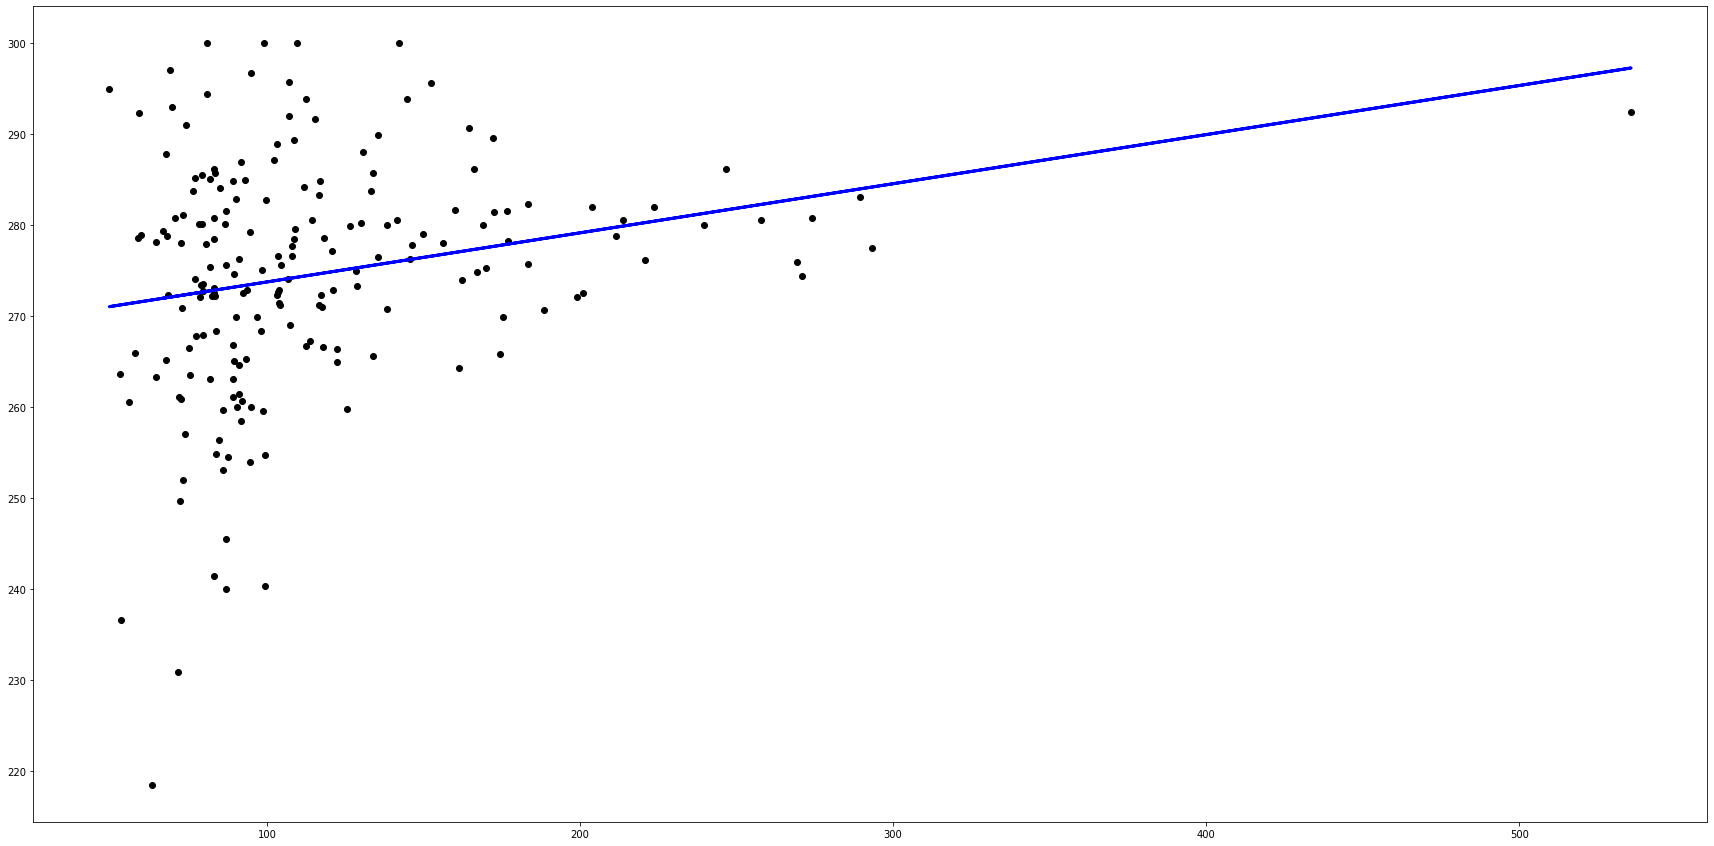

In [89]:
plt.figure(figsize=(30,15))
plt.scatter(X, Y,  color='black')
plt.plot(X, y_pred, color='blue', linewidth=3)

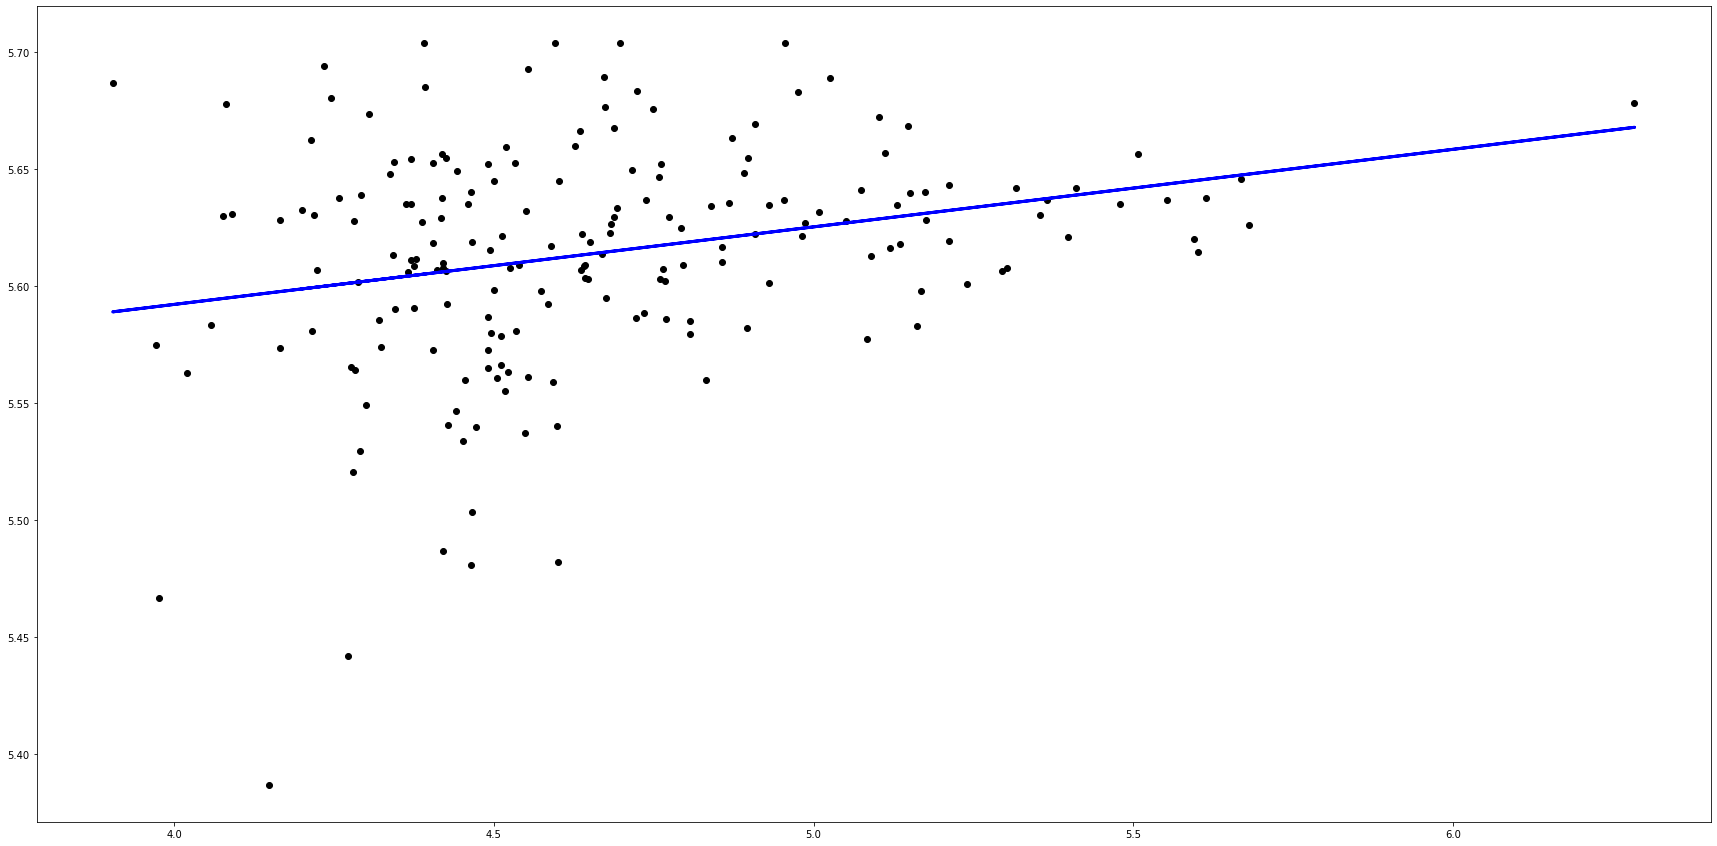

In [90]:
logX = numpy.log(X)
logy = numpy.log(Y)
logreg = LinearRegression().fit(logX, logy)
log_y_pred = logreg.predict(logX)

plt.figure(figsize=(30,15))
plt.scatter(logX, logy,  color='black')
plt.plot(logX, log_y_pred, color='blue', linewidth=3)